## Neyman-Pearson Test

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.stats
import pandas as pd
import sympy as S
from sympy import stats
s = stats.Normal('s',1,1)
n = stats.Normal('n',0,1)
x = S.symbols('x',real=True)

L = stats.density(s)(x)/stats.density(n)(x)
L = S.simplify(L)

In [3]:
from IPython.display import Math

In [4]:
Math(S.latex(L))

<IPython.core.display.Math object>

In [5]:
g = S.symbols('g',positive=True)
v=S.integrate(stats.density(n)(x),(x,S.Rational(1,2)+S.log(g),S.oo))
v=S.simplify(v)

In [6]:
Math(S.latex(v))

<IPython.core.display.Math object>

In [7]:
from scipy.special import erf
fv=S.lambdify(g,v-0.01,[numpy,{'erf':erf}])

In [8]:
from scipy.optimize import fsolve
sol,=fsolve(fv,.1)

In [9]:
sol

6.2111612425328078

In [10]:
S.nsolve(v-0.01,3)

mpf('6.2111612425328408')

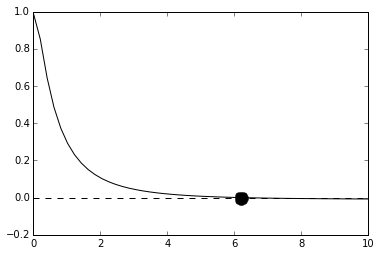

In [11]:
xi = np.linspace(0,10,50)
plot(xi,fv(xi),'k-')
plot(6.211,fv(6.211),'o',ms=13,color='k')
hlines(0,0,10,linestyles='--')

##  Generalized Likelihood Ratio test

$$ \Lambda = \frac{\sup_{\theta\in\Theta_0}L(\theta)}{\sup_\theta L(\theta)}$$

In [12]:
p = S.symbols('p',positive=True)
k = S.symbols('k',integer=True,positive=True)
n = 12

b=stats.Binomial('b',n,p)

In [13]:
from IPython.display import Math

In [14]:
v = stats.density(b)(k)

In [15]:
n0,n1,n2=5,6,7
S.var('k:3')

(k0, k1, k2)

In [16]:
numer=1
for ni,ki in zip((n0,n1,n2),(k0,k1,k2)):
    numer*=stats.density(b.subs(n,ni))(ki)
numer=numer.subs(p,(k0+k1+k2)/(n0+n1+n2))

denom=1
for ni,ki in zip((n0,n1,n2),(k0,k1,k2)):
    denom*=stats.density(b.subs(n,ni))(ki).subs(p,ki/ni)


In [17]:
Math(S.latex(numer))

<IPython.core.display.Math object>

In [18]:
Math(S.latex(denom))

<IPython.core.display.Math object>

In [19]:
foo=S.lambdify((k0,k1,k2),numer/denom) # Lambda function

In [20]:
p0,p1,p2 = 0.3,.4,.5

brvs= [ scipy.stats.binom(i,j) for i,j in zip((n0,n1,n2),(p0,p1,p2))]
def gen_sample(n=1):
    if n==1:
        return [i.rvs() for i in brvs]
    else:
        out = [gen_sample() for k in range(n)]
        return out

In [21]:
import itertools as it
out=[]
for i,j,k in it.product(range(n0+1),range(n1+1),range(n2+1)):
    out.append( ('{:2.8f}'.format(foo(i,j,k)),(i,j,k)))

In [22]:
from collections import defaultdict

d= defaultdict(list)
for i,j in out:
    d[i].append(j)
d=dict(d)

In [23]:
# rebuild numer for symbolic p
numer=1
for ni,ki in zip((n0,n1,n2),(k0,k1,k2)):
    numer*=stats.density(b.subs(n,ni))(ki)
    
nfoo=S.lambdify((k0,k1,k2),numer)

In [24]:
# rebuild denom for symbolic p

denom=1
for pi,ni,ki in zip(S.symbols('p:3'),(n0,n1,n2),(k0,k1,k2)):
    denom*=stats.density(b.subs([(n,ni),(p,pi)]))(ki)
    
dfoo=S.lambdify((k0,k1,k2),denom)

In [25]:
# Lambda density equivalence class
ds=pd.Series({float(i):j for i,j in d.iteritems()})


In [26]:
# accept H1 on these
accept_H1=set(sum((ds[ds.index < .05].tolist())))

In [27]:
ds.name='sets'
df=ds.reset_index('sets') # reconstruct  ds as DataFrame
df.set_index('index',inplace=True)

In [28]:
df['p']=df.sets.map(lambda i:sum([nfoo(*k) for k in i]))
df['pk']=df.sets.map(lambda i:sum([dfoo(*k) for k in i]))

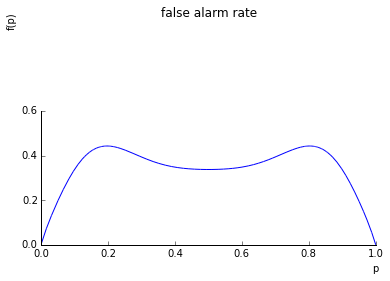

In [29]:
S.plot(df[df.index < .3].p.sum(),(p,0,1),title='false alarm rate',ylim=(0,1))

In [30]:
mean([foo(*i)<0.3 for i in gen_sample(1000)])

0.45700000000000002

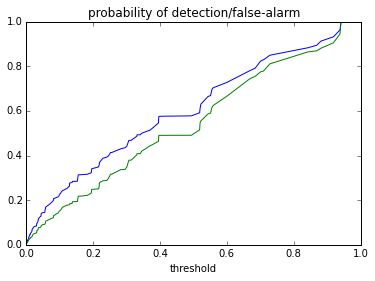

In [31]:
fig,ax=subplots()
tmp=df.pk.map(lambda i:i.subs([('p0',p0),('p1',p1),('p2',p2)])).astype(float).cumsum()
tmp.plot(ax=ax)
ax.axis(xmin=0,xmax=1,ymax=1)
ax.set_title('probability of detection/false-alarm')
ax.set_xlabel('threshold')


tmpfa=df.p.map(lambda i:i.subs(p,0.5)).astype(float).cumsum()
tmpfa.plot(ax=ax)
ax.axis(xmin=0,xmax=1,ymax=1)
ax.set_xlabel('threshold')

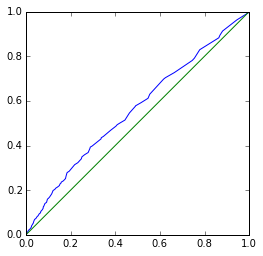

In [32]:
fig,ax=subplots()
ax.plot(tmpfa.values,tmp.values)
ax.set_aspect(1)
ax.axis(xmax=1,ymax=1)
ax.plot(linspace(0,1,10),linspace(0,1,10))

## Sample-based example

In [76]:
p0,p1,p2 = 0.3,.4,.5
n0,n1,n2 = 50,180,200

brvs= [ scipy.stats.binom(i,j) for i,j in zip((n0,n1,n2),(p0,p1,p2))]
def gen_sample(n=1):
    if n==1:
        return [i.rvs() for i in brvs]
    else:
        out = [gen_sample() for k in range(n)]
        return out

In [77]:
gen_sample()

[14, 68, 107]

In [85]:
k0,k1,k2 = gen_sample()
# k0,k1,k2,k3 = 41,26,13,17
# n0,n1,n2,n3 = 219,102,95,49
# Mathematica_Laboratories_for_Mathematical_Statistics_Baglivo.pdf, p.127

numer=1
for ni,ki in zip((n0,n1,n2),(k0,k1,k2)):
    numer*=stats.density(b.subs(n,ni))(ki)
numer=numer.subs(p,(k0+k1+k2)/(n0+n1+n2))

denom=1
for ni,ki in zip((n0,n1,n2),(k0,k1,k2)):
    denom*=stats.density(b.subs(n,ni))(ki).subs(p,ki/ni)

In [86]:
chsq=scipy.stats.chi2(2)
Lambda =-2*np.log(float(numer/denom))
print Lambda
print 1- chsq.cdf(Lambda)
print chsq.isf(.05)

8.05450847975
0.0178232010635
5.99146454711
